In [1]:
from midir import w1w2_condition
from tqdm import tqdm

import os
import numpy as np
from collections import OrderedDict as od
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import csv
from matplotlib import path
import matplotlib
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

from astropy.io import fits

from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles

#from astropy.units import cds
#cds.enable()

from astropy.cosmology import LambdaCDM, FlatLambdaCDM

from astropy.io import ascii
from astropy.io.ascii import masked
from astropy.table import Table

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from numpy import polyfit
from astropy.time import Time

#import uncertainties as unc  
#import uncertainties.unumpy as unp
import time

#import kcorrect.response

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

In [2]:
SAVE_FILEPATH = os.path.join(os.path.curdir, 'WISE variations/Final Plots 2.2.0/')
IMPORT_FILEPATH = os.path.join(os.path.curdir, 'WISE variations/')

In [5]:
manga_file = fits.open(IMPORT_FILEPATH + "mnsa-0.3.0.fits")
manga_hdu = manga_file[1]
manga_data = manga_hdu.data

pipe3d_file = fits.open(IMPORT_FILEPATH + 'SDSS17Pipe3D_v3_1_1.fits')
pipe3d_hdu = pipe3d_file[1]
pipe3d_data = pipe3d_hdu.data

wise_file = fits.open(IMPORT_FILEPATH + "WISE_statistics-7.2.7.fits")
wise_hdu = wise_file[1]
whdu = wise_hdu.data

jiyan_file = fits.open(IMPORT_FILEPATH + "jiyan-agn-0.3.2.fits")
jiyan_hdu = jiyan_file[1]
jhdu = jiyan_hdu.data

In [6]:
summary = manga_file[1].data
sps2 = manga_file[2].data

has_pipe3d = summary['ipipe3d '] != -1

sps2_matched = sps2[has_pipe3d]
summary_matched = summary[has_pipe3d]
wise_matched = whdu[has_pipe3d]

pipe3d_matched = pipe3d_data[summary_matched['ipipe3d ']]

In [7]:
wise_hdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3004 / length of dimension 1                          
NAXIS2  =                11273 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   26 / number of table fields                         
TTYPE1  = 'plateifu'                                                            
TFORM1  = '12A     '                                                            
TTYPE2  = 'ra      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'dec     '        

In [8]:
ssfr = pipe3d_matched['log_SFR_ssp']-pipe3d_matched['log_mass']

x1 = wise_matched['expected_W2_var_all_mags']
y1 = wise_matched['observed_W2_var']


w1 =  sps2_matched['maggies'][:, 5]
w2 =  sps2_matched['maggies'][:, 6]

plateifu = wise_matched['plateifu']

In [9]:
w1_app = -2.5 * np.log10(w1)
w2_app = -2.5 * np.log10(w2)

w12 = w1_app-w2_app

mask = (np.isfinite(w1_app) & np.isfinite(w2_app) & (x1!=-9999.) & (y1!=-9999.))


x1, y1, w12, ssfr, plateifu, ssfr, w1_app, w2_app = x1[mask], y1[mask], w12[mask], ssfr[mask], plateifu[mask], ssfr[mask], w1_app[mask], w2_app[mask]


C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\1998530037.py:1: RuntimeWarning: divide by zero encountered in log10
  w1_app = -2.5 * np.log10(w1)
C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\1998530037.py:2: RuntimeWarning: divide by zero encountered in log10
  w2_app = -2.5 * np.log10(w2)
C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\1998530037.py:2: RuntimeWarning: invalid value encountered in log10
  w2_app = -2.5 * np.log10(w2)
C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\1998530037.py:4: RuntimeWarning: invalid value encountered in subtract
  w12 = w1_app-w2_app


In [10]:
t = Table()
t['x'] = np.log10(x1)
t['y'] = np.log10(y1)
df = t.to_pandas()

In [11]:
binsize = 0.1
df = df.sort_values(by=['x'])
df_binned_mean = df.groupby(pd.cut(df["x"], np.arange(-4.5, -1.3, binsize))).mean()
df_binned_var = df.groupby(pd.cut(df["x"], np.arange(-4.5, -1.3, binsize))).var()
df_binned_count = df.groupby(pd.cut(df["x"], np.arange(-4.5, -1.3, binsize))).count()

x_mean, y_mean = df_binned_mean['x'].to_numpy(), df_binned_mean['y'].to_numpy()
x_var, y_var = df_binned_var['x'].to_numpy(), df_binned_var['y'].to_numpy()
x_count, y_count = df_binned_count['x'].to_numpy(), df_binned_count['y'].to_numpy()

y_mean[0:7]  = y_mean[7]


#df_binned_mean = df.groupby(pd.cut(df["x"], np.arange(x1.min(), x1.max(), binsize))).mean()
#df_binned_var = df.groupby(pd.cut(df["x"], np.arange(x1.min(), x1.max(), binsize))).var()
#df_binned_count = df.groupby(pd.cut(df["x"], np.arange(x1.min(), x1.max(), binsize))).count()

(-3.75, -0.75)

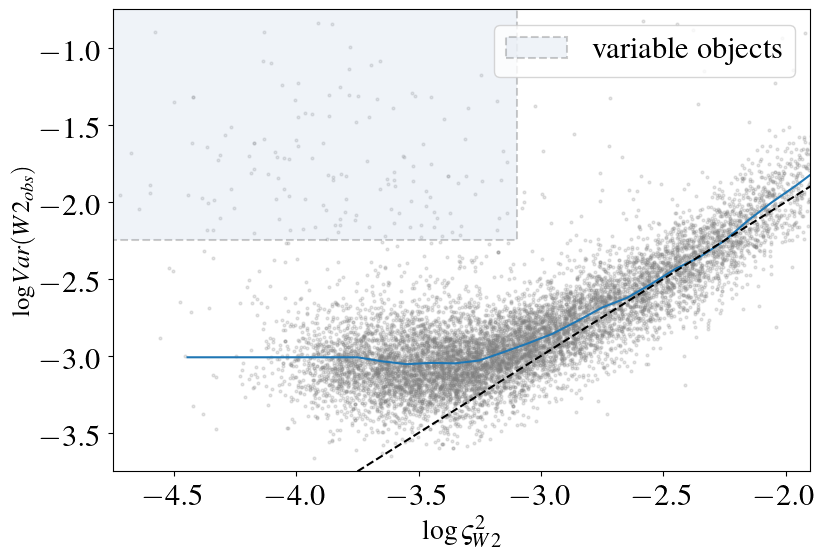

In [12]:
fig, ax = plt.subplots(figsize = (9,6))

axa = ax

blue_plot = axa.scatter(np.log10(x1), np.log10(y1), s = 4, alpha = 0.2, color='gray')
axa.plot((x_mean), (y_mean))
#var_plot = axa.scatter(np.log10(x1v), np.log10(y1v), s = 6, c='r', cmap='plasma_r')
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed')
axa.fill((-4.75, -4.75, -3.1, -3.1),(0, -2.25, -2.25, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
#ax.fill((-4.75, -4.75, -3.1, -3.1, -2.6, -2.6),(0, -2.3, -2.3, -2.3, -1.7, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')


##cbar2 = fig.colorbar(var_plot)
#cbar2.set_label(label = r'$W1-W2$',size=18)

axa.legend(loc='upper right')

axa.set_xlabel(r'$\log{\varsigma_{W2}^2}$', fontsize = 20)
axa.set_ylabel(r'$\log{Var(W2_{obs})}$', fontsize = 18)

axa.set_xlim(-4.75,-1.9)
axa.set_ylim(-3.75, -0.75)

In [13]:
N = 100000
galaxy_pifu = np.array([])

#select galaxies randomly:
galaxy_pifu =  plateifu[np.random.randint(0, plateifu.shape[0], size=N)]
print('step 1 done')

#finding indices for x1 and y1:
ind = np.array([])
for i in tqdm(range(N)):
    ind = np.append(ind, np.where(galaxy_pifu[i] == wise_matched['plateifu'])[0])
    
galaxy_x1 = np.log10(wise_matched['expected_W2_var_all_mags'][ind.astype(np.int64)])
galaxy_y1 = np.log10(wise_matched['observed_W2_var'][ind.astype(np.int64)])
print('step 2 done')

step 1 done


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9133.15it/s]

step 2 done


(-3.75, -0.75)

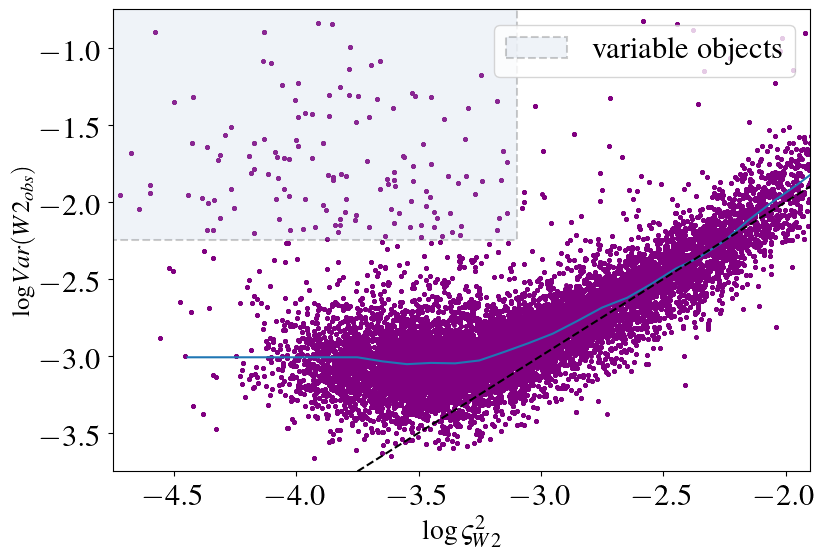

In [14]:
fig, ax = plt.subplots(figsize = (9,6))

axa = ax

blue_plot = axa.scatter(np.log10(x1), np.log10(y1), s = 4, alpha = 0.2, color='gray')
axa.plot((x_mean), (y_mean))
#var_plot = axa.scatter(np.log10(x1v), np.log10(y1v), s = 6, c='r', cmap='plasma_r')
axa.scatter(galaxy_x1, galaxy_y1, color='purple', s=5)
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed')
axa.fill((-4.75, -4.75, -3.1, -3.1),(0, -2.25, -2.25, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
#ax.fill((-4.75, -4.75, -3.1, -3.1, -2.6, -2.6),(0, -2.3, -2.3, -2.3, -1.7, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')


##cbar2 = fig.colorbar(var_plot)
#cbar2.set_label(label = r'$W1-W2$',size=18)

axa.legend(loc='upper right')

axa.set_xlabel(r'$\log{\varsigma_{W2}^2}$', fontsize = 20)
axa.set_ylabel(r'$\log{Var(W2_{obs})}$', fontsize = 18)

axa.set_xlim(-4.75,-1.9)
axa.set_ylim(-3.75, -0.75)

In [15]:
#find closest averaged x1 bin for galaxy 
y1_intercept = np.array([])
for i in tqdm(range(N)):
    y1_intercept = np.append(y1_intercept, y_mean[np.abs(x_mean-galaxy_x1[i]).argmin()])

print('step 3 done')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 49707.95it/s]

step 3 done


(-3.75, -0.75)

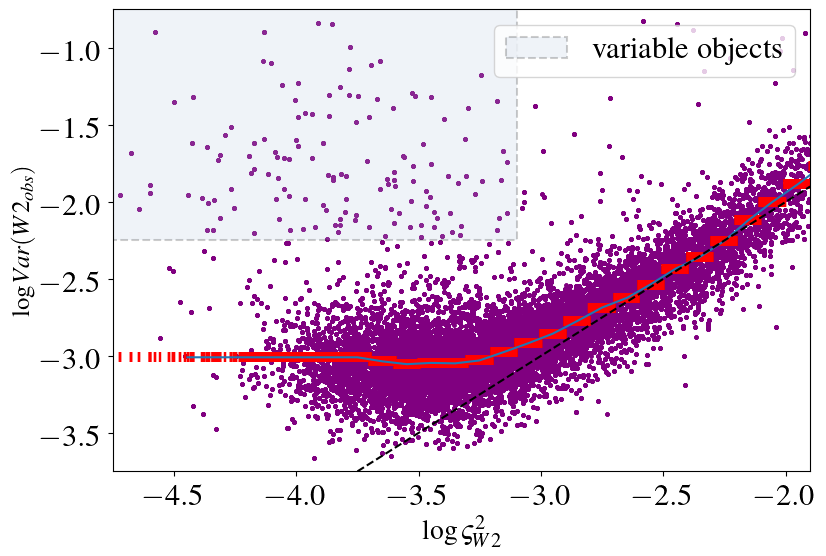

In [16]:
fig, ax = plt.subplots(figsize = (9,6))

axa = ax

blue_plot = axa.scatter(np.log10(x1), np.log10(y1), s = 4, alpha = 0.2, color='gray')
axa.plot((x_mean), (y_mean))
axa.scatter(galaxy_x1, galaxy_y1, color='purple', s=5)
#var_plot = axa.scatter(np.log10(x1v), np.log10(y1v), s = 6, c='r', cmap='plasma_r')
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed')
axa.fill((-4.75, -4.75, -3.1, -3.1),(0, -2.25, -2.25, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
#ax.fill((-4.75, -4.75, -3.1, -3.1, -2.6, -2.6),(0, -2.3, -2.3, -2.3, -1.7, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
axa.scatter(galaxy_x1, y1_intercept, c='r', marker='|', s=55)

##cbar2 = fig.colorbar(var_plot)
#cbar2.set_label(label = r'$W1-W2$',size=18)

axa.legend(loc='upper right')

axa.set_xlabel(r'$\log{\varsigma_{W2}^2}$', fontsize = 20)
axa.set_ylabel(r'$\log{Var(W2_{obs})}$', fontsize = 18)

axa.set_xlim(-4.75,-1.9)
axa.set_ylim(-3.75, -0.75)

In [17]:
#creating normal distribution with appropriate variance (from y1_vals)
mc_y1 = np.array([])
for i in tqdm(range(N)):
    distribution = np.random.normal(scale=np.sqrt(10**(y1_intercept[i])), size=25)
    mc_y1 = np.append(mc_y1, np.log10(distribution.var(axis=0, ddof=1)))

print('step 4 done')
#print(np.log10(distribution.var(ddof=1)))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 24678.73it/s]

step 4 done


(-3.75, -0.75)

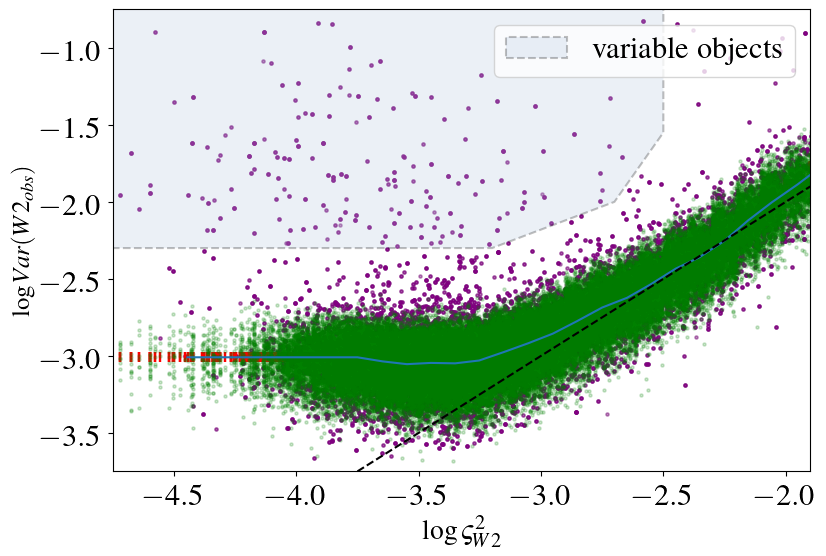

In [18]:
fig, ax = plt.subplots(figsize = (9,6))

axa = ax

blue_plot = axa.scatter(np.log10(x1), np.log10(y1), s = 4, alpha = 0.2, color='gray')
axa.plot((x_mean), (y_mean))
axa.scatter(galaxy_x1, galaxy_y1, color='purple', alpha=0.15, s=5)
#var_plot = axa.scatter(np.log10(x1v), np.log10(y1v), s = 6, c='r', cmap='plasma_r')
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed')
#axa.fill((-4.75, -4.75, -3.1, -3.1),(0, -2.25, -2.25, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
ax.fill((-4.75, -4.75, -3.2, -3.2, -2.7,  -2.5, -2.5),(0, -2.3, -2.3, -2.3, -2., -1.55, 0), color = 'lightsteelblue', alpha = 0.25, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
axa.scatter(galaxy_x1, y1_intercept, c='r', marker='|', s=55)
axa.scatter(np.repeat(galaxy_x1,1), mc_y1, c='g', s=5, alpha=0.2)
##cbar2 = fig.colorbar(var_plot)
#cbar2.set_label(label = r'$W1-W2$',size=18)

axa.legend(loc='upper right')

axa.set_xlabel(r'$\log{\varsigma_{W2}^2}$', fontsize = 20)
axa.set_ylabel(r'$\log{Var(W2_{obs})}$', fontsize = 18)

axa.set_xlim(-4.75,-1.9)
axa.set_ylim(-3.75, -0.75)

In [31]:
#sorting arrays:
idxmc = np.argsort(galaxy_x1)
sorted_x1mc = galaxy_x1[idxmc]
sorted_y1mc = mc_y1[idxmc]

idx = np.argsort(x1)
sorted_x1 = np.log10(x1)[idx]
sorted_y1 = np.log10(y1)[idx]



In [32]:
x_vals = np.array([-4.2, -4., -3.8, -3.6, -3.4, -3.2, -3., -2.8, -2.6])
slices = []
slices_mc = []


for i in range(x_vals.shape[0]):
    xmc_slice = ((sorted_x1mc>x_vals[i]) & (sorted_x1mc<(x_vals[i]+binsize)))
    x_slice = ((sorted_x1>x_vals[i]) & (sorted_x1<(x_vals[i]+binsize)))
    
    ymc_slice = sorted_y1mc[xmc_slice]
    ymc_slice_norm = (ymc_slice-ymc_slice.mean())/ymc_slice.std()
    
    y_slice = sorted_y1[x_slice]
    y_slice_norm = (y_slice-y_slice.mean())/y_slice.std()
    
    #slices_mc.append(ymc_slice_norm)
    #slices.append(y_slice_norm)
    slices_mc.append(ymc_slice)
    slices.append(y_slice)


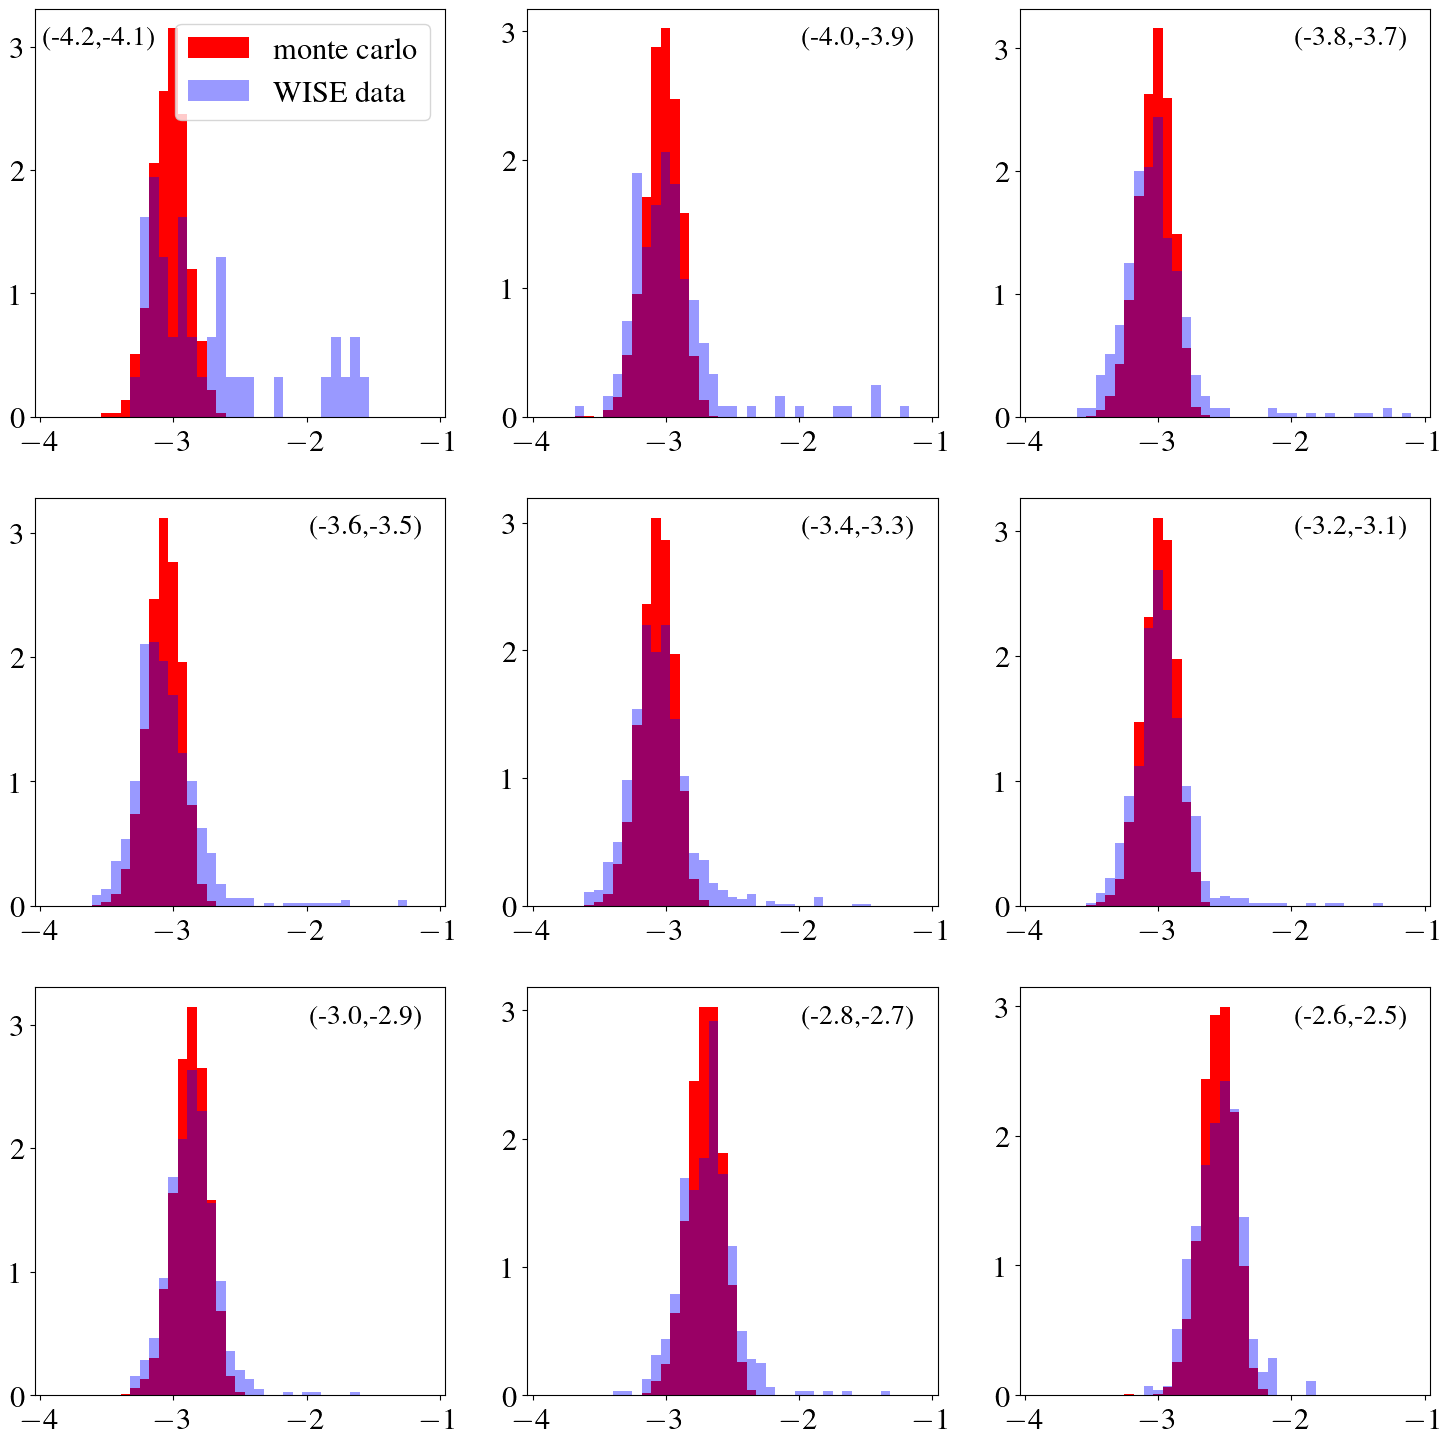

In [33]:
bins = np.linspace(-3.9,-1.1, 40)
#bins = np.linspace(-5,5, 40)
fig, ax = plt.subplots(figsize=(18,18), ncols=3, nrows=3)
for i, axes in enumerate(ax.ravel()):

    if i==0:
        axes.hist(slices_mc[i], bins=bins, color='r', density=True, label='monte carlo')
        axes.hist(slices[i], bins=bins, color='blue', alpha=0.4, density=True, label='WISE data')
        axes.text(0.02,0.91,'('+str(x_vals[i]) + ',' + str((x_vals[i]+binsize).round(2))+')', fontsize=20, fontweight='bold', transform=axes.transAxes)
        axes.legend(loc='upper right')
        continue
    
    axes.hist(slices_mc[i], bins=bins, color='r', alpha=1, density=True)
    axes.hist(slices[i], bins=bins, color='blue', alpha=0.4, density=True)
    axes.text(0.67,0.91,'('+str(x_vals[i]) + ',' + str((x_vals[i]+binsize).round(2))+')', fontsize=20, fontweight='bold', transform=axes.transAxes)
    #axes.legend(loc='upper right')
#plt.savefig(SAVE_FILEPATH+'monte_carlo_dist.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

(array([0.        , 0.0047807 , 0.        , 0.00717105, 0.06453946,
        0.09322366, 0.21752188, 0.39918851, 0.78642526, 1.35532864,
        1.7712496 , 2.03896884, 2.13936355, 1.70192944, 1.16649097,
        0.82228052, 0.47567972, 0.24142538, 0.10278506, 0.08366226,
        0.05258771, 0.04780701, 0.02629385, 0.0286842 , 0.03585526,
        0.0286842 , 0.0286842 , 0.0239035 , 0.04302631, 0.01195175,
        0.03107455, 0.0191228 , 0.0095614 , 0.00717105, 0.01673245,
        0.0191228 , 0.0143421 , 0.00717105, 0.0047807 ]),
 array([-3.9       , -3.82820513, -3.75641026, -3.68461538, -3.61282051,
        -3.54102564, -3.46923077, -3.3974359 , -3.32564103, -3.25384615,
        -3.18205128, -3.11025641, -3.03846154, -2.96666667, -2.89487179,
        -2.82307692, -2.75128205, -2.67948718, -2.60769231, -2.53589744,
        -2.46410256, -2.39230769, -2.32051282, -2.24871795, -2.17692308,
        -2.10512821, -2.03333333, -1.96153846, -1.88974359, -1.81794872,
        -1.74615385, -1.6743

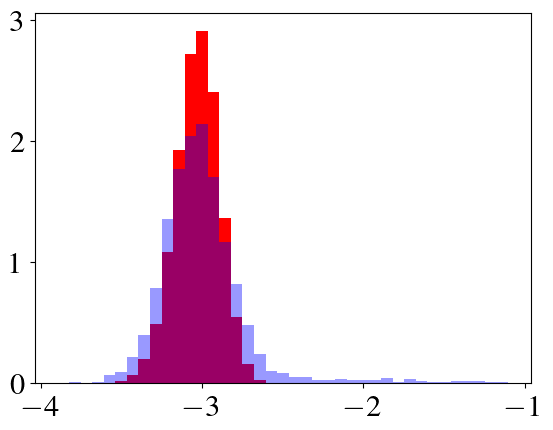

In [34]:
#bins=np.linspace(-4.5, -1, 40)
cutmc = (sorted_x1mc<-3)
cut = (sorted_x1<-3)

xmctest = sorted_x1mc[cutmc]
ymctest = sorted_y1mc[cutmc]
ymctest_norm = (ymctest-ymctest.mean())/ymctest.std()
    
xtest = sorted_x1[cut]
ytest = sorted_y1[cut]
ytest_norm = (ytest-ytest.mean())/ytest.std()

plt.hist(ymctest, color='red', bins=bins, density=True)
plt.hist(ytest, bins=bins, color='blue', alpha=0.4, density=True)
#plt.savefig(SAVE_FILEPATH+'monte_carlo_cumulative_dist.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [35]:
sorted_x1mc.shape, ymc_newvar.shape, x_bins.shape

((100000,), (99774,), (50,))

In [36]:
len(binned_ymc)

0

In [37]:
#increasing width of distribution
x_bins=np.arange(-5, -0, 0.1)

binned_xmc = []
binned_ymc = []
#binned_y=[]

for i in range(x_bins.shape[0]):
    maskmc = ((sorted_x1mc>x_bins[i]) & (sorted_x1mc<(x_bins[i]+binsize)))
    #mask = ((sorted_x1>x_bins[i]) & (sorted_x1<(x_bins[i]+binsize)))
    binned_xmc.append(sorted_x1mc[maskmc])
    binned_ymc.append(sorted_y1mc[maskmc])
    #binned_y.append(sorted_y1[mask])
    
ymc_newvar = np.array([])
for array in binned_ymc:
    std = array.std(ddof=1)
    
    #normalized data: 
    array_norm = (array-np.nanmean(array))/array.std(ddof=1)
    scale = 1.25
    ymc_newvar = np.append(ymc_newvar, (scale*std*array_norm+array.mean())) #+array.mean()

sorted_x1mc = sorted_x1mc[:-(sorted_x1mc.shape[0]-ymc_newvar.shape[0])]
#y_zeromean = np.array([])
#for array in binned_y:
    #y_zeromean = np.append(y_zeromean, array-array.mean())

C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\3748839256.py:20: RuntimeWarning: Mean of empty slice
  array_norm = (array-np.nanmean(array))/array.std(ddof=1)
C:\Users\paiaa\AppData\Local\Temp\ipykernel_46160\3748839256.py:22: RuntimeWarning: Mean of empty slice.
  ymc_newvar = np.append(ymc_newvar, (scale*std*array_norm+array.mean())) #+array.mean()


In [38]:
sorted_x1mc.shape, ymc_newvar.shape

((99774,), (99774,))

In [39]:
 #blue line is the truth
    
#select a random galaxy, find which bin it is in, take the corresponding blue point as the variance of a distribution, sample 15

(-3.75, -0.75)

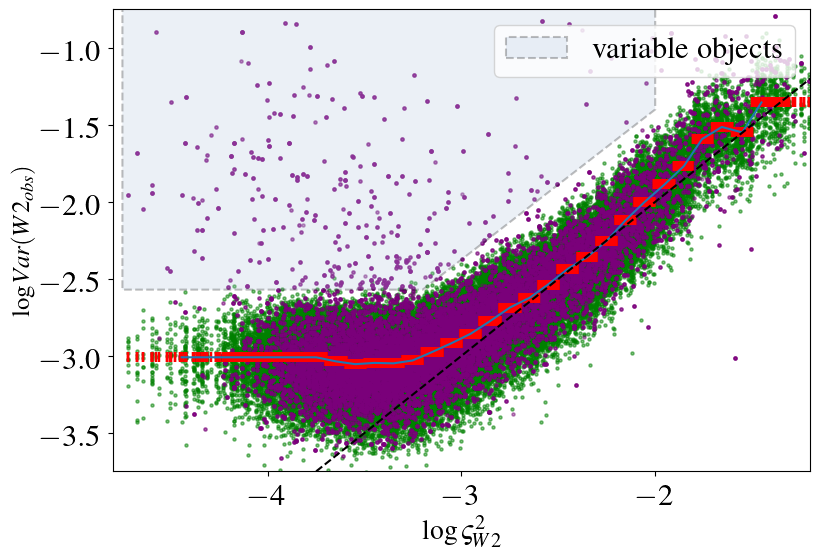

In [40]:
fig, ax = plt.subplots(figsize = (9,6))

axa = ax

blue_plot = axa.scatter(np.log10(x1), np.log10(y1), s = 4, alpha = 0.2, color='gray')
axa.plot((x_mean), (y_mean))
axa.scatter(sorted_x1mc, ymc_newvar, c='g', s=5, alpha=0.5)
axa.scatter(galaxy_x1, galaxy_y1, color='purple', alpha=0.15, s=5)
#var_plot = axa.scatter(np.log10(x1v), np.log10(y1v), s = 6, c='r', cmap='plasma_r')
axa.axline((0, 0), slope= 1, color = 'black', linestyle = 'dashed')
#axa.fill((-4.75, -4.75, -3.1, -3.1),(0, -2.25, -2.25, 0), color = 'lightsteelblue', alpha = 0.2, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
ax.fill((-4.75, -4.75, -3.2,  -2, -2),(0, -2.57, -2.57, -1.4, 0), color = 'lightsteelblue', alpha = 0.25, edgecolor = 'black', linestyle = 'dashed', lw = 1.5,  label = 'variable objects')
axa.scatter(galaxy_x1, y1_intercept, c='r', marker='|', s=55)

##cbar2 = fig.colorbar(var_plot)
#cbar2.set_label(label = r'$W1-W2$',size=18)

axa.legend(loc='upper right')

axa.set_xlabel(r'$\log{\varsigma_{W2}^2}$', fontsize = 20)
axa.set_ylabel(r'$\log{Var(W2_{obs})}$', fontsize = 18)

axa.set_xlim(-4.8,-1.2)
axa.set_ylim(-3.75, -0.75)

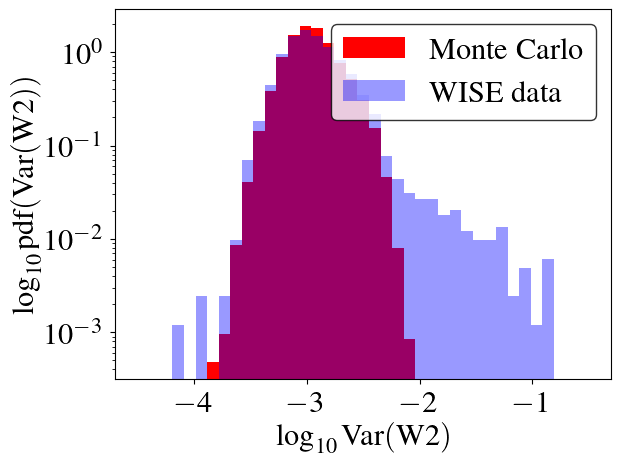

In [47]:
bins=np.linspace(-4.5, -0.5, 40)
cutmc = (sorted_x1mc<-2.5)
cut = (sorted_x1<-2.5)

xmctest = sorted_x1mc[cutmc]
ymctest = (ymc_newvar[cutmc])
ymctest_norm = (ymctest-ymctest.mean())/ymctest.std()
    
xtest = sorted_x1[cut]
ytest = sorted_y1[cut]
ytest_norm = (ytest-ytest.mean())/ytest.std()

plt.hist(ymctest, color='red', bins=bins, density=True, label='Monte Carlo')
plt.hist(ytest, bins=bins, color='blue', alpha=0.4, density=True, label='WISE data')

#plt.ylim(0.001,5)
plt.yscale('log')
plt.ylabel(r'$\log_{10}{\rm pdf(Var(W2))}$')
plt.xlabel(r'$\log_{10}{\rm Var(W2)}$')
plt.legend(edgecolor='k')
#plt.savefig(SAVE_FILEPATH+'mc_pdf.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)#

In [267]:
y_zeromean

NameError: name 'y_zeromean' is not defined

In [254]:
#x_vals = np.array([-4.2, -4., -3.8, -3.6, -3.4, -3.2, -3., -2.8, -2.6])
x_vals = np.array([-4.2, -4., -3.6, -3.4])
slices = []
slices_mc = []


for i in range(x_vals.shape[0]):
    xmc_slice = ((sorted_x1mc>x_vals[i]) & (sorted_x1mc<(x_vals[i]+binsize)))
    x_slice = ((sorted_x1>x_vals[i]) & (sorted_x1<(x_vals[i]+binsize)))
    
    ymc_slice = ymc_newvar[xmc_slice]
    ymc_slice_norm = (ymc_slice-ymc_slice.mean())/ymc_slice.std()
    
    y_slice = sorted_y1[x_slice]
    y_slice_norm = (y_slice-y_slice.mean())/y_slice.std()
    
    #slices_mc.append(ymc_slice_norm)
    #slices.append(y_slice_norm)
    slices_mc.append(ymc_slice)
    slices.append(y_slice)


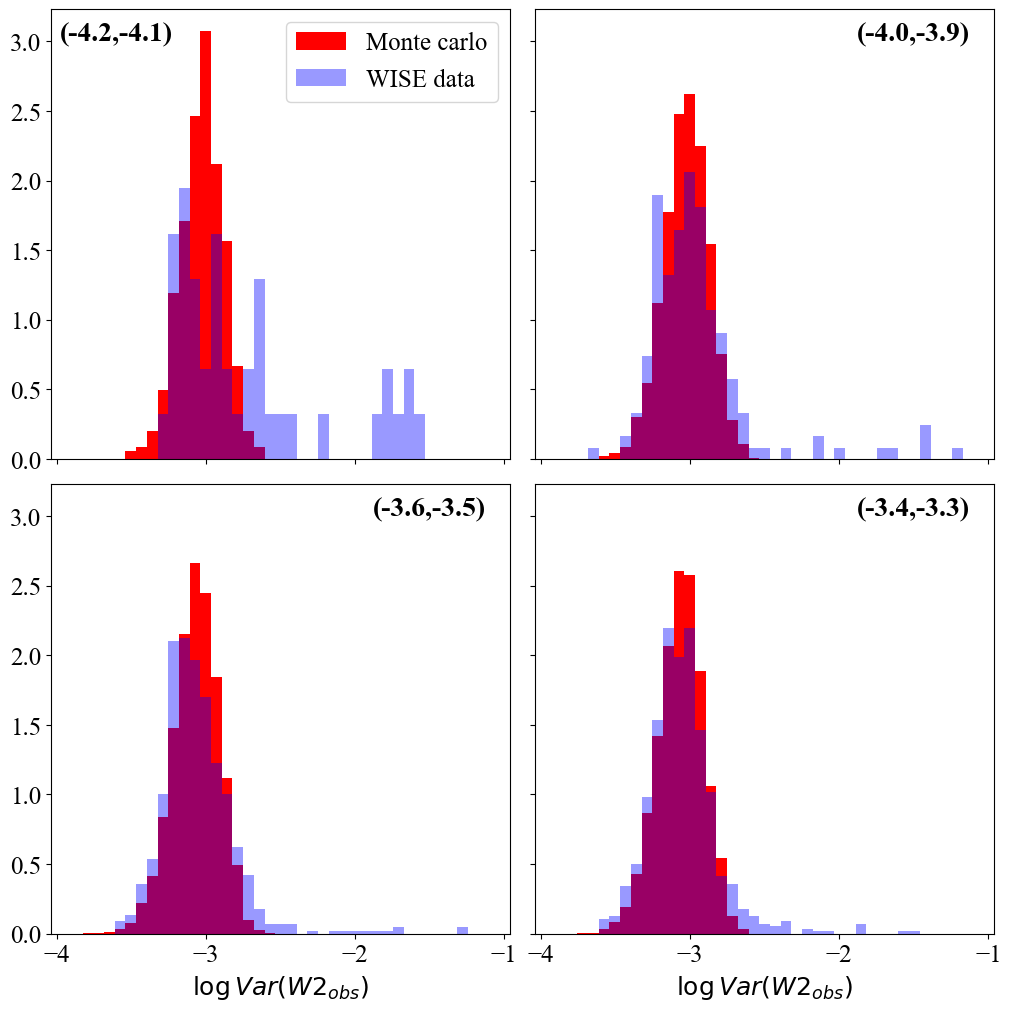

In [255]:
bins = np.linspace(-3.9,-1.1, 40)
#bins = np.linspace(-5,5, 40)
fig, ax = plt.subplots(figsize=(10,10), ncols=x_vals.shape[0]//2,  nrows=x_vals.shape[0]//2, sharex=True, sharey=True, constrained_layout=True)
for i, axes in enumerate(ax.ravel()):

    if i==0:
        axes.hist(slices_mc[i], bins=bins, color='r', density=True, label='Monte carlo')
        axes.hist(slices[i], bins=bins, color='blue', alpha=0.4, density=True, label='WISE data')
        axes.text(0.02,0.93,'('+str(x_vals[i]) + ',' + str((x_vals[i]+binsize).round(2))+')', fontsize=20, fontweight='bold', transform=axes.transAxes)
        axes.legend(loc='upper right')
        continue
    
    axes.hist(slices_mc[i], bins=bins, color='r', alpha=1, density=True)
    axes.hist(slices[i], bins=bins, color='blue', alpha=0.4, density=True)
    axes.text(0.7,0.93,'('+str(x_vals[i]) + ',' + str((x_vals[i]+binsize).round(2))+')', fontsize=20, fontweight='bold', transform=axes.transAxes)
    
    if i in [2,3]:
        axes.set_xlabel(r'$\log{Var(W2_{obs})}$', fontsize=18)
    #axes.legend(loc='upper right')
#plt.savefig(SAVE_FILEPATH+'monte_carlo_dist_30percentvar_4x4.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)